<a href="https://colab.research.google.com/github/midnightripper/IDEC/blob/main/Copy_of_Copy_of_idec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras.layers import Layer, InputSpec
import numpy as np
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import csv, os

def dataloader(path):
    data = scipy.io.loadmat(path)
    AF = data['AF']
    modified_rows1 = AF[:-2]
    last_rows1 = AF[-2:]
    CF = data['CF']
    concatenated_array = np.concatenate((modified_rows1, CF,last_rows1), axis=0)
    new=concatenated_array
    u, count = np.unique(new[-1], return_counts=True)
    a = u[np.logical_or(count < 2, count > 2)]
    c = new[:, np.isin(new[-1], a, invert=True)]
    x = c[0:-2]; y = c[-2]; w = c[-1];
    return x.T, y.T, w.T, data['CF_info']

def normalization(feats):
    df = pd.DataFrame(feats)
    scaler = StandardScaler()
    x_new = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return x_new

In [ ]:
import argparse
original_dim = 38

# train_path = filee; test_path = filee.replace('train','test')
train_path='/content/drive/MyDrive/finalData/TypicalFA_comb1/GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
test_path='/content/drive/MyDrive/finalData/TypicalFA_comb1/GER_test_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
x, y, wtrain1, info_train1 = dataloader(train_path);
xtest, ytest, wtest1, info_test1 = dataloader(test_path);
xtest= normalization(xtest)
x= normalization(x)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

def calculate_nmi(true_labels, predicted_labels):
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return nmi

def calculate_ari(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    return ari

In [ ]:
def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    _, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(range(w.shape[0]), col_ind)]) * 1.0 / y_pred.size

In [ ]:
def autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
    h = Dense(dims[0], name='decoder_0')(h)
    return Model(inputs=x, outputs=h)

# Train the autoencoder
autoencoder = autoencoder([x.shape[-1], 500, 500, 2000, 10])  # Adjust dimensions as needed
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x, x, batch_size=256, epochs=50)  # Adjust batch size and epochs as needed
# Save the autoencoder weights
autoencoder.save_weights('autoencoder_weights.h5')

Epoch 1/50
16/16 [==============================] - 8s 6ms/step - loss: 0.7531
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.4535
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2962
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2033
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.1492
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.1183
Epoch 7/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0993
Epoch 8/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0846
Epoch 9/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0761
Epoch 10/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0678
Epoch 11/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0636
Epoch 12/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0568
Epoch 13/50
16/16 [==============================

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import numpy as np
from scipy.optimize import linear_sum_assignment

def autoencoder(dims, act='relu', dropout_rate=0.2):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[0], name='decoder_0')(h)
    return Model(inputs=x, outputs=h)

# Assuming you have the true cluster labels for x_train in y_true

# Assuming you have the autoencoder model and weights already trained
autoencoder = autoencoder([x.shape[-1], 500, 500, 2000, 10], dropout_rate=0.2)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x, x, batch_size=256, epochs=50,verbose=0)  # Adjust batch size and epochs as needed

# Encode the data and predict the cluster labels using the autoencoder
encoded_data = autoencoder.predict(x)
y_pred = np.argmax(encoded_data, axis=1)

# Calculate NMI and ARI scores
nmi_score = normalized_mutual_info_score(y, y_pred)
ari_score = adjusted_rand_score(y, y_pred)

print("Normalized Mutual Information (NMI):", nmi_score)
print("Adjusted Rand Index (ARI):", ari_score)


124/124 [==============================] - 0s 2ms/step
Normalized Mutual Information (NMI): 0.037055923162075496
Adjusted Rand Index (ARI): 0.00852128560288435


124/124 [==============================] - 0s 2ms/step


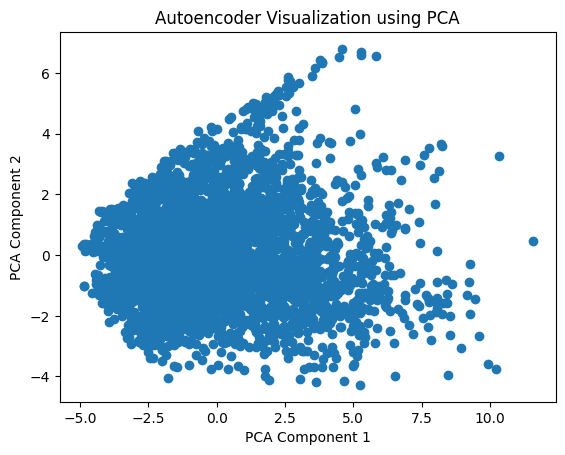

In [ ]:
from sklearn.decomposition import PCA

# Assuming you have trained the autoencoder and have the encoded_data
# encoded_data is the output of the encoder part of the autoencoder
encoded_data = autoencoder.predict(x)

# Apply PCA for dimensionality reduction to 2D or 3D
pca = PCA(n_components=2)  # Set n_components=3 for 3D visualization
encoded_pca = pca.fit_transform(encoded_data)

# Visualize the encoded data using matplotlib or any other plotting library
import matplotlib.pyplot as plt

plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1])
plt.title('Autoencoder Visualization using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


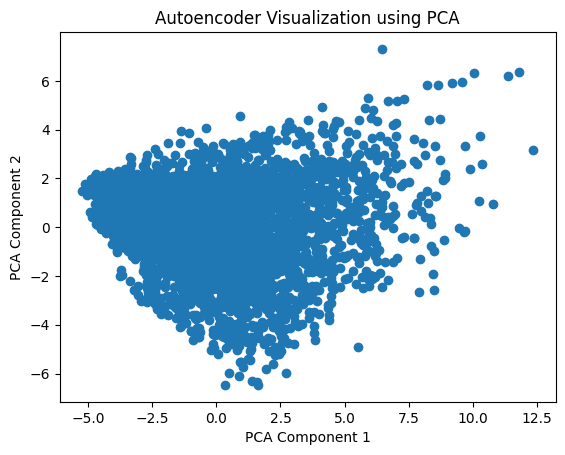

In [ ]:
from sklearn.decomposition import PCA

# Assuming you have trained the autoencoder and have the encoded_data
# encoded_data is the output of the encoder part of the autoencoder
encoded_data = x

# Apply PCA for dimensionality reduction to 2D or 3D
pca = PCA(n_components=2)  # Set n_components=3 for 3D visualization
encoded_pca = pca.fit_transform(encoded_data)

# Visualize the encoded data using matplotlib or any other plotting library
import matplotlib.pyplot as plt

plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1])
plt.title('Autoencoder Visualization using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
def autoencoder(dims, act='relu', dropout_rate=0.2):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[0], name='decoder_0')(h)
    return Model(inputs=x, outputs=h)

# Assuming you have the true cluster labels for x_train in y_true

# Assuming you have the autoencoder model and weights already trained
autoencoder = autoencoder([x.shape[-1], 200, 200, 500, 10], dropout_rate=0.2)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x, x, batch_size=256, epochs=50,verbose=0)  # Adjust batch size and epochs as needed

# Encode the data and predict the cluster labels using the autoencoder
encoded_data = autoencoder.predict(x)
y_pred = np.argmax(encoded_data, axis=1)

# Calculate NMI and ARI scores
nmi_score = normalized_mutual_info_score(y, y_pred)
ari_score = adjusted_rand_score(y, y_pred)

print("Normalized Mutual Information (NMI):", nmi_score)
print("Adjusted Rand Index (ARI):", ari_score)


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def autoencoder(dims, act='relu', dropout_rate=0.2):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[0], name='decoder_0')(h)
    return Model(inputs=x, outputs=h)

# Assuming you have the true cluster labels for x_train in y_true

# Assuming you have the autoencoder model and weights already trained
autoencoder = autoencoder([x.shape[-1], 200, 200, 500, 19], dropout_rate=0.2)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x, x, batch_size=256, epochs=50,verbose=0)  # Adjust batch size and epochs as needed

# Encode the data and predict the cluster labels using the autoencoder
encoded_data = autoencoder.predict(x)
y_pred = np.argmax(encoded_data, axis=1)

encoded_data = autoencoder.predict(x)

# Calculate the reconstruction error (MSE) between the original input data (x) and the reconstructed output (encoded_data)
reconstruction_error = mean_squared_error(x, encoded_data)

print("Reconstruction Error (MSE):", reconstruction_error)

124/124 [==============================] - 0s 2ms/step
Reconstruction Error (MSE): 0.07380565584438994
Normalized Mutual Information (NMI): 0.0346403047713573
Adjusted Rand Index (ARI): 0.007477849968000788


In [ ]:
def autoencoder(dims, act='relu', dropout_rate=0.2):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[0], name='decoder_0')(h)
    return Model(inputs=x, outputs=h)

# Assuming you have the true cluster labels for x_train in y_true

# Assuming you have the autoencoder model and weights already trained
autoencoder = autoencoder([x.shape[-1], 200, 200, 500, 19], dropout_rate=0.2)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x, x, batch_size=256, epochs=50,verbose=0)  # Adjust batch size and epochs as needed

# Encode the data and predict the cluster labels using the autoencoder
encoded_data = autoencoder.predict(x)
y_pred = np.argmax(encoded_data, axis=1)

encoded_data = autoencoder.predict(x)

# Calculate the reconstruction error (MSE) between the original input data (x) and the reconstructed output (encoded_data)
reconstruction_error = mean_squared_error(x, encoded_data)

print("Reconstruction Error (MSE):", reconstruction_error)

124/124 [==============================] - 0s 3ms/step
Reconstruction Error (MSE): 12.836927878198797


In [ ]:
def autoencoder(dims, act='relu', dropout_rate=0.2):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
        h = Dropout(dropout_rate)(h)  # Add Dropout layer after each Dense layer
    h = Dense(dims[0], name='decoder_0')(h)
    return Model(inputs=x, outputs=h)

# Assuming you have the true cluster labels for x_train in y_true

# Assuming you have the autoencoder model and weights already trained
autoencoder = autoencoder([x.shape[-1], 200, 200, 500, 19], dropout_rate=0.2)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
autoencoder.fit(x, x, batch_size=256, epochs=50,verbose=0)  # Adjust batch size and epochs as needed

# Encode the data and predict the cluster labels using the autoencoder
encoded_data = autoencoder.predict(x)
y_pred = np.argmax(encoded_data, axis=1)

encoded_data = autoencoder.predict(x)

# Calculate the reconstruction error (MSE) between the original input data (x) and the reconstructed output (encoded_data)
reconstruction_error = mean_squared_error(x, encoded_data)

print("Reconstruction Error (MSE):", reconstruction_error)

124/124 [==============================] - 0s 2ms/step
Reconstruction Error (MSE): 794.5197685918629


In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

# Assuming you have `y_true` and `y_pred` after clustering using the autoencoder

def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    _, col_ind = linear_sum_assignment(w.max() - w)
    acc = sum([w[i, j] for i, j in zip(range(w.shape[0]), col_ind)]) * 1.0 / y_pred.size
    return acc

def calculate_nmi_and_ari(y_true, y_pred):
    nmi_score = normalized_mutual_info_score(y_true, y_pred)
    ari_score = adjusted_rand_score(y_true, y_pred)
    return nmi_score, ari_score

# Assuming you have `y_true` and `y_pred` after clustering using the autoencoder
# Calculate NMI and ARI scores
nmi_score, ari_score = calculate_nmi_and_ari(y, y_pred)

# Calculate clustering accuracy using the cluster_acc function
clustering_accuracy = cluster_acc(y_true, y_pred)

print("Clustering Accuracy:", clustering_accuracy)
print("Normalized Mutual Information (NMI):", nmi_score)
print("Adjusted Rand Index (ARI):", ari_score)

In [ ]:
class ClusteringLayer(Dense):
    def __init__(self, n_clusters, alpha=1.0, **kwargs):
        self.n_clusters = n_clusters
        self.alpha = alpha
        super(ClusteringLayer, self).__init__(n_clusters, **kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=tf.float32, shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim),
                                        initializer='glorot_uniform', name='clusters')
        self.built = True

    def get_config(self):
        config = super(ClusteringLayer, self).get_config()
        config['n_clusters'] = self.n_clusters
        config['alpha'] = self.alpha
        return config

    def call(self, inputs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

class IDEC(object):
    def __init__(self, dims, n_clusters=2, alpha=1.0):
        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder = autoencoder(self.dims)

    def initialize_model(self, ae_weights=None, gamma=0.1, optimizer='adam'):
        if ae_weights is not None:
            self.autoencoder.load_weights(ae_weights)
            print('Pretrained AE weights are loaded successfully.')
        else:
            print('Training the autoencoder from scratch.')
            self.autoencoder.compile(loss='mse', optimizer=optimizer)
            self.autoencoder.fit(x, x, batch_size=self.batch_size, epochs=200)  # You can adjust the epochs as needed

        hidden = self.autoencoder.get_layer(name='encoder_%d' % (self.n_stacks - 1)).output
        self.encoder = Model(inputs=self.autoencoder.input, outputs=hidden)

        # prepare IDEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.autoencoder.input,
                           outputs=[clustering_layer, self.autoencoder.output])
        self.model.compile(loss={'clustering': 'kld', 'decoder_0': 'mse'},
                           loss_weights=[gamma, 1],
                           optimizer=optimizer)

    def fit(self, x, y=None, batch_size=256, maxiter=2e4, tol=1e-3, update_interval=140, save_dir='./results/idec'):
        print('Update interval', update_interval)
        save_interval = int(x.shape[0] / batch_size) * 5
        print('Save interval', save_interval)
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/idec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L'])
        logwriter.writeheader()

        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)
                y_pred = q.argmax(1)
                if y is not None:
                    acc = cluster_acc(y, y_pred)
                    nmi = normalized_mutual_info_score(y, y_pred)
                    ari = adjusted_rand_score(y, y_pred)
                    loss = np.round(loss, 5)
                    logwriter.writerow({'iter': ite, 'acc': acc, 'nmi': nmi, 'ari': ari, 'L': loss[0]})
                    print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss)

                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)

                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            if (index + 1) * batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * batch_size::], y=[p[index * batch_size::], x[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * batch_size:(index + 1) * batch_size],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    x[index * batch_size:(index + 1) * batch_size]])
                index += 1

            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/IDEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/IDEC_model_' + str(ite) + '.h5')

            ite += 1

        logfile.close()
        print('saving model to:', save_dir + '/IDEC_model_final.h5')
        self.model.save_weights(save_dir + '/IDEC_model_final.h5')

        return y_pred

    def predict_clusters(self, x):
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(axis=1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

#  batch_size=256, tol=0.001, maxiter=20000, update_interval=140,

In [ ]:
def idec_imp(batch_size,tol,maxiter,intervel):
    x, y, wtrain1, info_train1 = dataloader(train_path)
    xtest, ytest, wtest1, info_test1 = dataloader(test_path)
    xtest = normalization(xtest)
    x = normalization(x)

    idec = IDEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=2)
    idec.initialize_model(ae_weights='autoencoder_weights.h5', gamma=0.1, optimizer='adam')
    idec.fit(x, y=y, batch_size=batch_size, tol=tol, maxiter=maxiter, update_interval=intervel, save_dir='./results/idec')

    # Show the final results
    y_pred = idec.predict_clusters(x)
    print('ACC:', cluster_acc(y, y_pred))
    nmi_score = calculate_nmi(y, y_pred)
    ari_score = calculate_ari(y, y_pred)

    print("Normalized Mutual Information (NMI):", nmi_score)
    print("Adjusted Rand Index (ARI):", ari_score)


In [ ]:
idec_imp(256,0.001,20000,140)

FileNotFoundError: ignored

In [ ]:
idec_imp(512,0.001,20000,140)

Pretrained AE weights are loaded successfully.
Update interval 140
Save interval 35
124/124 [==============================] - 0s 1ms/step
Iter 0 : Acc 0.5287588294651867 , nmi 0.002833029784108982 , ari 0.0030865106413905763 ; loss= [0 0 0]
saving model to: ./results/idec/IDEC_model_0.h5
saving model to: ./results/idec/IDEC_model_35.h5
saving model to: ./results/idec/IDEC_model_70.h5
saving model to: ./results/idec/IDEC_model_105.h5
Iter 140 : Acc 0.5302724520686175 , nmi 0.002950404031668609 , ari 0.0034335819674308067 ; loss= [0.016   0.00745 0.01525]
saving model to: ./results/idec/IDEC_model_140.h5
saving model to: ./results/idec/IDEC_model_175.h5
saving model to: ./results/idec/IDEC_model_210.h5
saving model to: ./results/idec/IDEC_model_245.h5
Iter 280 : Acc 0.5343087790110999 , nmi 0.0036483253067880676 , ari 0.004469883247599752 ; loss= [0.02169 0.0142  0.02027]
saving model to: ./results/idec/IDEC_model_280.h5
saving model to: ./results/idec/IDEC_model_315.h5
saving model to:

In [ ]:
idec_imp(128,0.001,20000,140)

Pretrained AE weights are loaded successfully.
Update interval 140
Save interval 150
124/124 [==============================] - 0s 1ms/step
Iter 0 : Acc 0.5252270433905146 , nmi 0.002154605665795058 , ari 0.0023217822488051597 ; loss= [0 0 0]
saving model to: ./results/idec/IDEC_model_0.h5
Iter 140 : Acc 0.5287588294651867 , nmi 0.0026625095461960567 , ari 0.0030760943792922206 ; loss= [0.02202 0.00848 0.02118]
saving model to: ./results/idec/IDEC_model_150.h5
Iter 280 : Acc 0.5282542885973764 , nmi 0.0024751065342578345 , ari 0.0029544847632481403 ; loss= [0.02166 0.0132  0.02034]
saving model to: ./results/idec/IDEC_model_300.h5
Iter 420 : Acc 0.5317860746720484 , nmi 0.0030398873145374033 , ari 0.003797526924977554 ; loss= [0.03203 0.01952 0.03007]
saving model to: ./results/idec/IDEC_model_450.h5


KeyboardInterrupt: ignored

In [ ]:
def calculate_accuracy(arr1, arr2):
    count = sum(1 for itr1, itr2 in zip(arr1, arr2) if itr1 == itr2)
    return count / len(arr1)

In [ ]:
print(calculate_accuracy(y,y_pred))

0.5486881937436933


In [ ]:
def flip(arr):
  result = []
  for num in arr:
      if num == 1:
          result.append(0)
      else:
          result.append(1)
  return result

In [ ]:
y_pred_flip=flip(y_pred)

In [ ]:
print(calculate_accuracy(y,y_pred_flip))

0.4760343087790111


In [ ]:
print(y_pred)

[0 1 0 ... 1 1 1]
